# Pre-Procesing
Objetivo:
Preparar los datos para el entrenamiento de modelos de reconocimiento de gestos, asegurando calidad y balance en el dataset.

## 1. Carga de datos
- Importar el DataFrame generado en el notebook Data Exploration
- Verificar la estructura: columnas relevantes como filepath, label y posible metadatos

In [1]:
import pandas as pd

# Cargar el DataFrame generado en el notebook de exploración
# Si lo guardaste como CSV, ajusta el nombre de archivo según corresponda
df = pd.read_csv('../data/hagrid_help_dataframe.csv')

# Verificar la estructura del DataFrame
print("Columnas del DataFrame:", df.columns)
print("Primeras filas:")
print(df.head())
print("Cantidad total de muestras:", len(df))
print("Cantidad de clases:", df['label'].nunique())
print("Clases:", df['label'].unique())


Columnas del DataFrame: Index(['image_path', 'label', 'split'], dtype='object')
Primeras filas:
                                          image_path label split
0  ../data/hagrid_dataset/stop/922db148-6e53-4642...  stop   val
1  ../data/hagrid_dataset/stop/60e378f1-2578-41b8...  stop   val
2  ../data/hagrid_dataset/stop/5332009e-e834-4d16...  stop   val
3  ../data/hagrid_dataset/stop/491c829a-2d66-48e4...  stop   val
4  ../data/hagrid_dataset/stop/fd1913d5-e629-4534...  stop   val
Cantidad total de muestras: 68811
Cantidad de clases: 2
Clases: ['stop' 'three_gun']


## 2. Limpieza de datos
- Eliminar muestras corruptas
- Eliminar duplicados
- Eliminar filas con información faltante
- Verificar existencia de imágenes

In [2]:
import os

# 1. Eliminar filas con información faltante
df = df.dropna()
print("Tamaño del dataset después de eliminar filas con información faltante:", len(df))

# 2. Eliminar duplicados
df = df.drop_duplicates()
print("Tamaño del dataset después de eliminar duplicados:", len(df))

# 3. Verificar existencia de imágenes y eliminar muestras corruptas/no existentes
df = df[df['image_path'].apply(lambda x: os.path.exists(x))]
print("Tamaño del dataset después de verificar existencia de imágenes:", len(df))

# Opcional: Mostrar cuántas filas se


Tamaño del dataset después de eliminar filas con información faltante: 68811
Tamaño del dataset después de eliminar duplicados: 68811
Tamaño del dataset después de verificar existencia de imágenes: 68811


## 3. Balanceo de clases
- Analizar al distribución de clases
- Aplicar técnicas de balanceo
- Asegurar que el dataset final esté balanceado


Distribución de clases en val antes del balanceo:
label
stop         3000
three_gun    3000
Name: count, dtype: int64


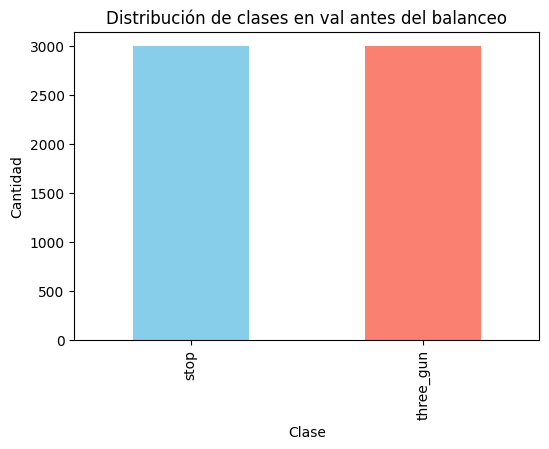


Distribución de clases en val después del balanceo:
label
stop         3000
three_gun    3000
Name: count, dtype: int64


/tmp/ipykernel_39145/768652018.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_split_balanced = df_split.groupby('label').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


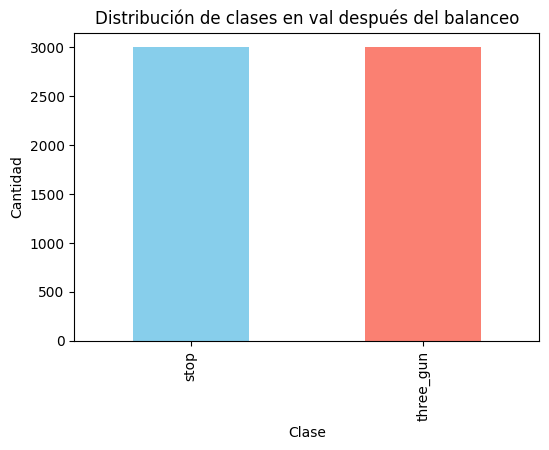


Distribución de clases en train antes del balanceo:
label
three_gun    29543
stop         23268
Name: count, dtype: int64


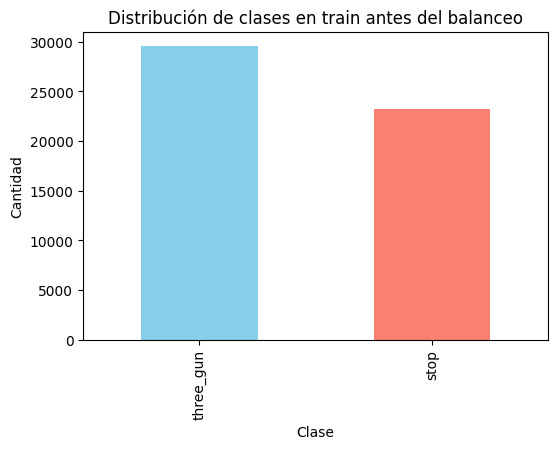

/tmp/ipykernel_39145/768652018.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_split_balanced = df_split.groupby('label').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)



Distribución de clases en train después del balanceo:
label
stop         23268
three_gun    23268
Name: count, dtype: int64


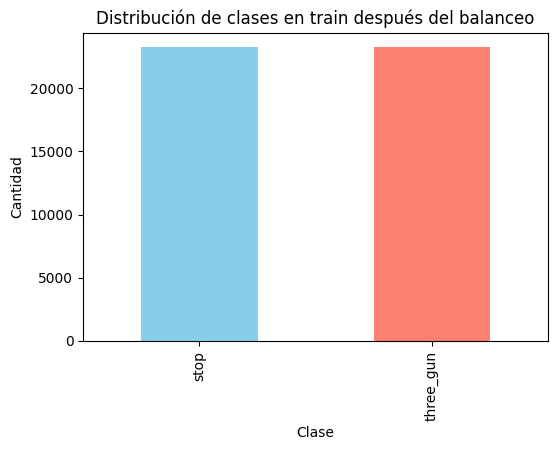


Distribución de clases en test antes del balanceo:
label
stop         5000
three_gun    5000
Name: count, dtype: int64


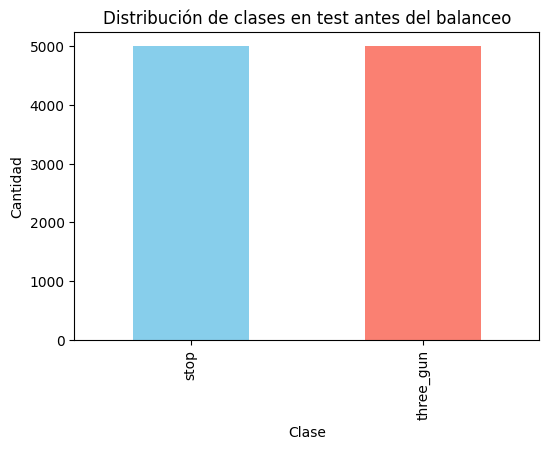

/tmp/ipykernel_39145/768652018.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_split_balanced = df_split.groupby('label').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)



Distribución de clases en test después del balanceo:
label
stop         5000
three_gun    5000
Name: count, dtype: int64


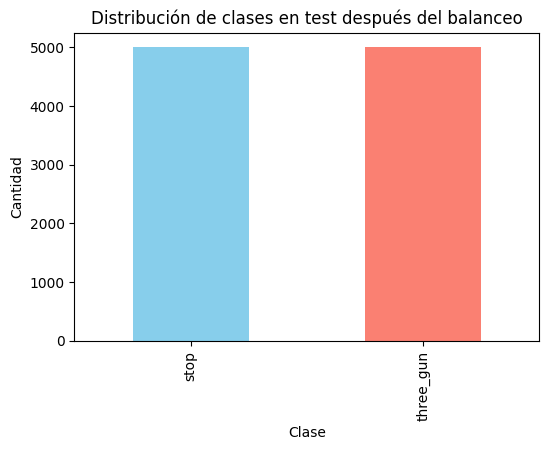

In [3]:
import matplotlib.pyplot as plt

# Balanceo por split (train, val, test)
df_balanced = pd.DataFrame()
for split in df['split'].unique():
    df_split = df[df['split'] == split]
    class_counts = df_split['label'].value_counts()
    print(f"\nDistribución de clases en {split} antes del balanceo:")
    print(class_counts)
    plt.figure(figsize=(6,4))
    class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'Distribución de clases en {split} antes del balanceo')
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.show()
    min_count = class_counts.min()
    df_split_balanced = df_split.groupby('label').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
    balanced_counts = df_split_balanced['label'].value_counts()
    print(f"\nDistribución de clases en {split} después del balanceo:")
    print(balanced_counts)
    plt.figure(figsize=(6,4))
    balanced_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'Distribución de clases en {split} después del balanceo')
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.show()
    df_balanced = pd.concat([df_balanced, df_split_balanced], ignore_index=True)

# df_balanced contiene el dataset balanceado por split para usar en los siguientes pasos


## 4. Escalado y normalización
- Normalización de imágenes
- Redimensionar imágenes
- Preparar los datos para el modelo

In [9]:
import numpy as np
import cv2

IMG_SIZE = (224, 224)  # Tamaño reducido para ahorrar memoria

def preprocess_image(img_path, img_size=IMG_SIZE):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return img

def batch_generator(df, batch_size=100, img_size=IMG_SIZE):
    for start in range(0, len(df), batch_size):
        end = start + batch_size
        batch_df = df.iloc[start:end].copy()
        batch_df['image_array'] = batch_df['image_path'].apply(lambda x: preprocess_image(x, img_size))
        batch_df = batch_df[batch_df['image_array'].notnull()]
        X_batch = np.stack(batch_df['image_array'].values)
        y_batch = batch_df['label'].values
        yield X_batch, y_batch

# Ejemplo de uso: procesar todo el dataset por lotes
for X_batch, y_batch in batch_generator(df_balanced, batch_size=1000):
    print(f"Batch shape X: {X_batch.shape}, y: {y_batch.shape}")
    # Aquí puedes entrenar tu modelo o guardar cada batch
    # break  # Elimina el break para procesar todos los batches



Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X: (1000, 224, 224, 3), y: (1000,)
Batch shape X

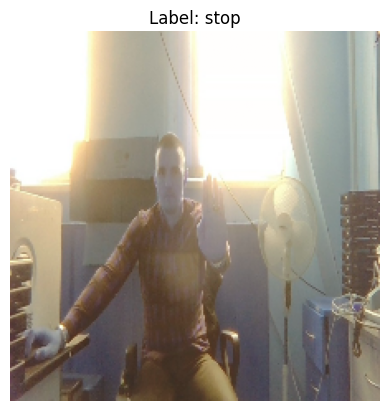

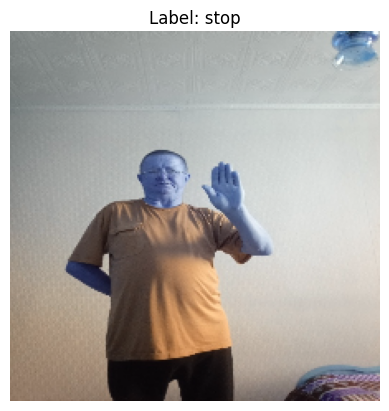

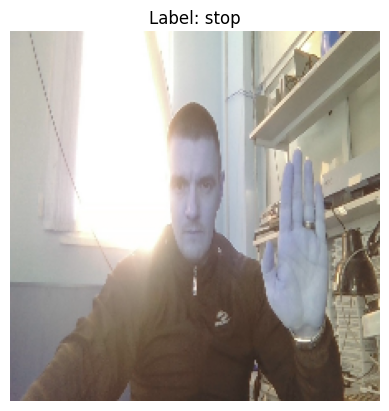

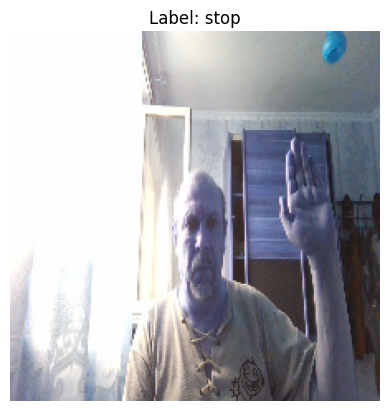

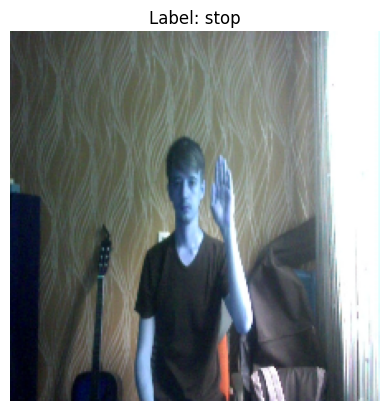

Shape: (224, 224, 3)
Min pixel value: 0.08627451
Max pixel value: 1.0


In [12]:
import matplotlib.pyplot as plt

# Selecciona algunas imágenes procesadas
sample_df = df_balanced.head(5).copy()
sample_df['image_array'] = sample_df['image_path'].apply(preprocess_image)

for i, img in enumerate(sample_df['image_array']):
    plt.imshow(img)
    plt.title(f"Label: {sample_df.iloc[i]['label']}")
    plt.axis('off')
    plt.show()

img_array = sample_df['image_array'].iloc[0]
print("Shape:", img_array.shape)
print("Min pixel value:", img_array.min())
print("Max pixel value:", img_array.max())


## 5. Partición de datos
- Dividir el dataset
- Respetar la proporción y el balanceo de clases
- Guardar o exportar los conjuntos

In [10]:
# Mantener la división original por split
df_train = df_balanced[df_balanced['split'] == 'train']
df_val = df_balanced[df_balanced['split'] == 'val']
df_test = df_balanced[df_balanced['split'] == 'test']

print(f"Train: {len(df_train)} muestras")
print(f"Val: {len(df_val)} muestras")
print(f"Test: {len(df_test)} muestras")

# Guardar cada conjunto en CSV
df_train.to_csv('../data/hagrid_train.csv', index=False)
df_val.to_csv('../data/hagrid_val.csv', index=False)
df_test.to_csv('../data/hagrid_test.csv', index=False)

Train: 46536 muestras
Val: 6000 muestras
Test: 10000 muestras
